# Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [2]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Zooplankton variables
    micro = ds_bio.microzooplankton
    meso = ds_bio.mesozooplankton

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, micro, meso)


# Masking

In [3]:
def masking (depth, temp, saline, mask, micro, meso):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    micro = micro.where(mask[0,depth]==1)
    meso = meso.where(mask[0,depth]==1)

    return (temp, saline, micro, meso)

# SOM

In [4]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size, lr = 0.1)
    temp_som.fit(inputs3, epochs = 5)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2.transpose(), predictions, clusters)


# Printing

In [5]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [6]:
def plotting (depth, clusters, unique, micro, meso):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': micro[0,depth].y, 'x': micro[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    cmap = plt.get_cmap('tab10', unique.max()+1)
    cmap.set_bad('gray')
    fig, ax = plt.subplots(2,2, figsize=(10, 15))
    clus = map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique)
    cbar.set_label('Clusters [count]')
    
    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.95, 
        wspace=0.15, 
        hspace=0.15)
        
    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')
    micro[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    meso[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Microzooplankton')
    ax[1,0].title.set_text('Mesozooplankton')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters, ' + str(date[0].year) + '/' + month + '/' + day)
    
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 5552 

The minimum temperature for cluster 0 is 6.6 degrees Celsius
The maximum temperature for cluster 0 is 9.76 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 20.47 g/kg
The maximum salinity for cluster 0 is 25.19 g/kg
The mean salinity for cluster 0 is 23.81 g/kg 


The amount of grid boxes for cluster 1 is 11583 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 9.45 degrees Celsius
The mean temperature for cluster 1 is 7.24 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 24.21 g/kg
The mean salinity for cluster 1 is 18.45 g/kg 


The amount of grid boxes for cluster 2 is 7679 

The minimum temperature for cluster 2 is 7.67 degrees Celsius
The maximum temperature for cluster 2 is 9.09 degrees Celsius
The mean temperature for cluster 2 is 8.19 degrees Celsius 

The mi

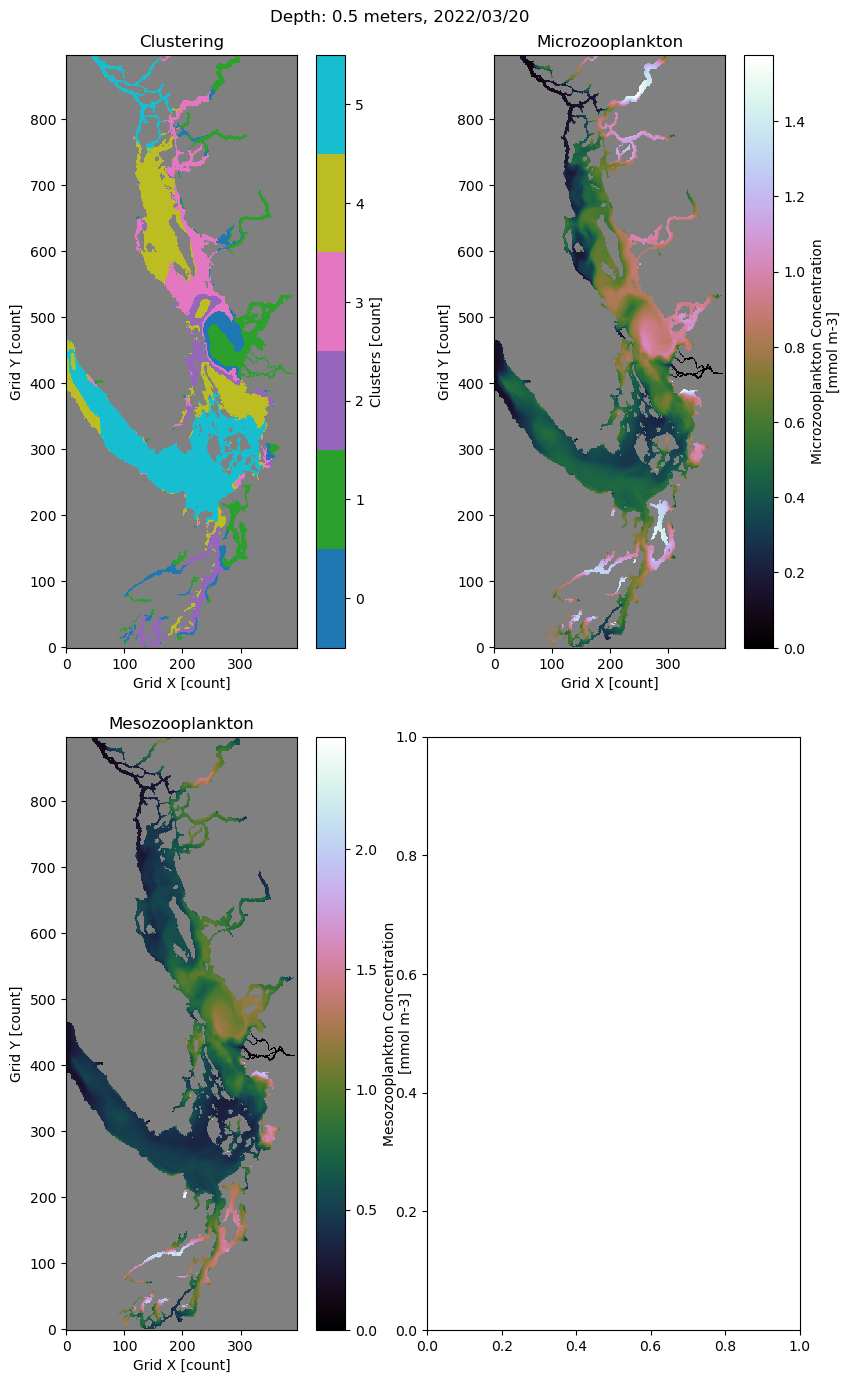

The amount of grid boxes for cluster 0 is 19961 

The minimum temperature for cluster 0 is 7.46 degrees Celsius
The maximum temperature for cluster 0 is 8.87 degrees Celsius
The mean temperature for cluster 0 is 7.92 degrees Celsius 

The minimum salinity for cluster 0 is 28.01 g/kg
The maximum salinity for cluster 0 is 29.91 g/kg
The mean salinity for cluster 0 is 28.78 g/kg 


The amount of grid boxes for cluster 1 is 26827 

The minimum temperature for cluster 1 is 5.95 degrees Celsius
The maximum temperature for cluster 1 is 8.11 degrees Celsius
The mean temperature for cluster 1 is 7.68 degrees Celsius 

The minimum salinity for cluster 1 is 28.09 g/kg
The maximum salinity for cluster 1 is 31.21 g/kg
The mean salinity for cluster 1 is 30.03 g/kg 


The amount of grid boxes for cluster 2 is 9404 

The minimum temperature for cluster 2 is 7.52 degrees Celsius
The maximum temperature for cluster 2 is 9.92 degrees Celsius
The mean temperature for cluster 2 is 8.12 degrees Celsius 

Th

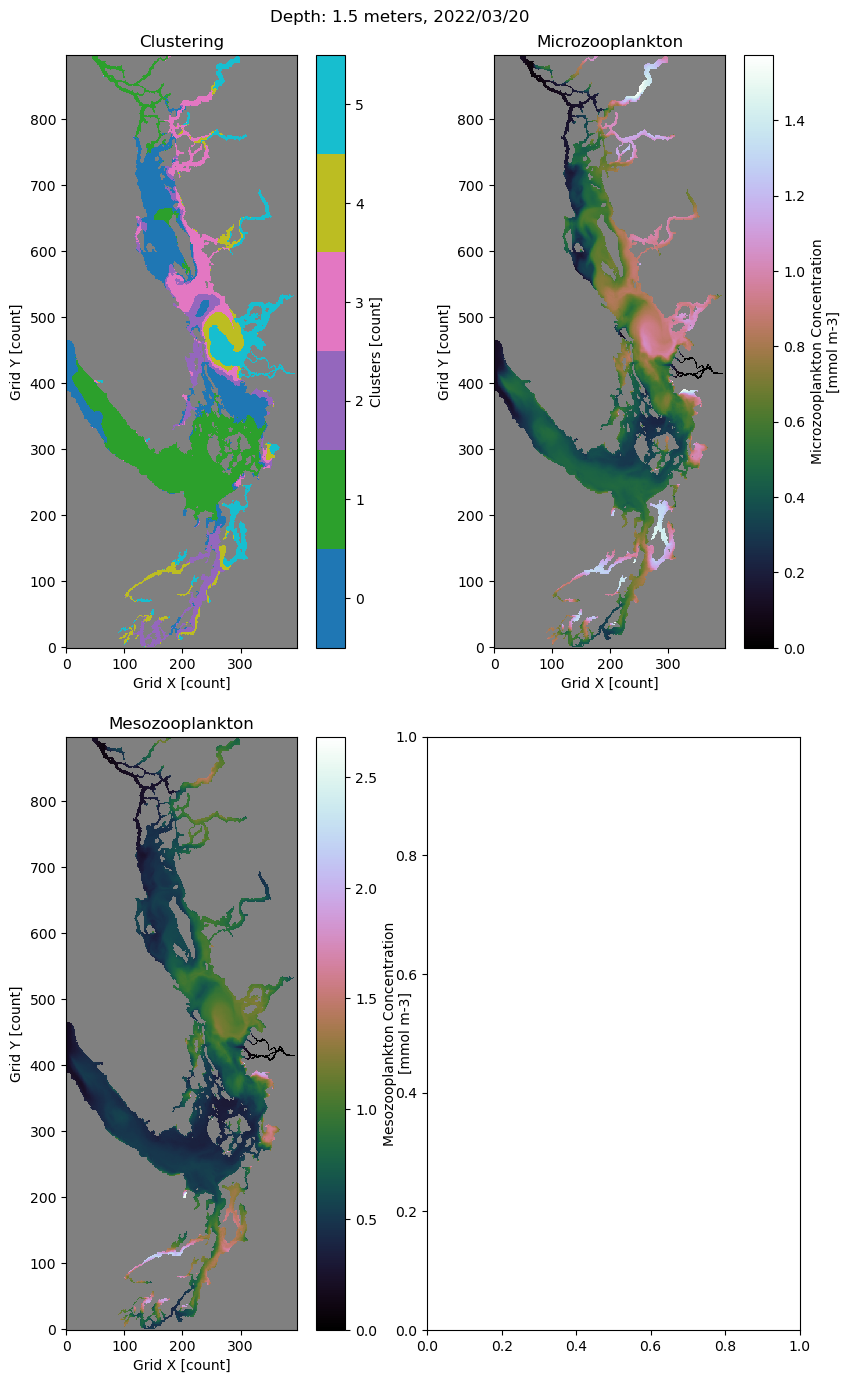

The amount of grid boxes for cluster 0 is 17081 

The minimum temperature for cluster 0 is 7.64 degrees Celsius
The maximum temperature for cluster 0 is 10.04 degrees Celsius
The mean temperature for cluster 0 is 8.02 degrees Celsius 

The minimum salinity for cluster 0 is 27.67 g/kg
The maximum salinity for cluster 0 is 29.85 g/kg
The mean salinity for cluster 0 is 28.81 g/kg 


The amount of grid boxes for cluster 1 is 26873 

The minimum temperature for cluster 1 is 6.01 degrees Celsius
The maximum temperature for cluster 1 is 8.12 degrees Celsius
The mean temperature for cluster 1 is 7.7 degrees Celsius 

The minimum salinity for cluster 1 is 28.78 g/kg
The maximum salinity for cluster 1 is 31.23 g/kg
The mean salinity for cluster 1 is 30.09 g/kg 


The amount of grid boxes for cluster 2 is 9327 

The minimum temperature for cluster 2 is 7.17 degrees Celsius
The maximum temperature for cluster 2 is 10.02 degrees Celsius
The mean temperature for cluster 2 is 8.17 degrees Celsius 

T

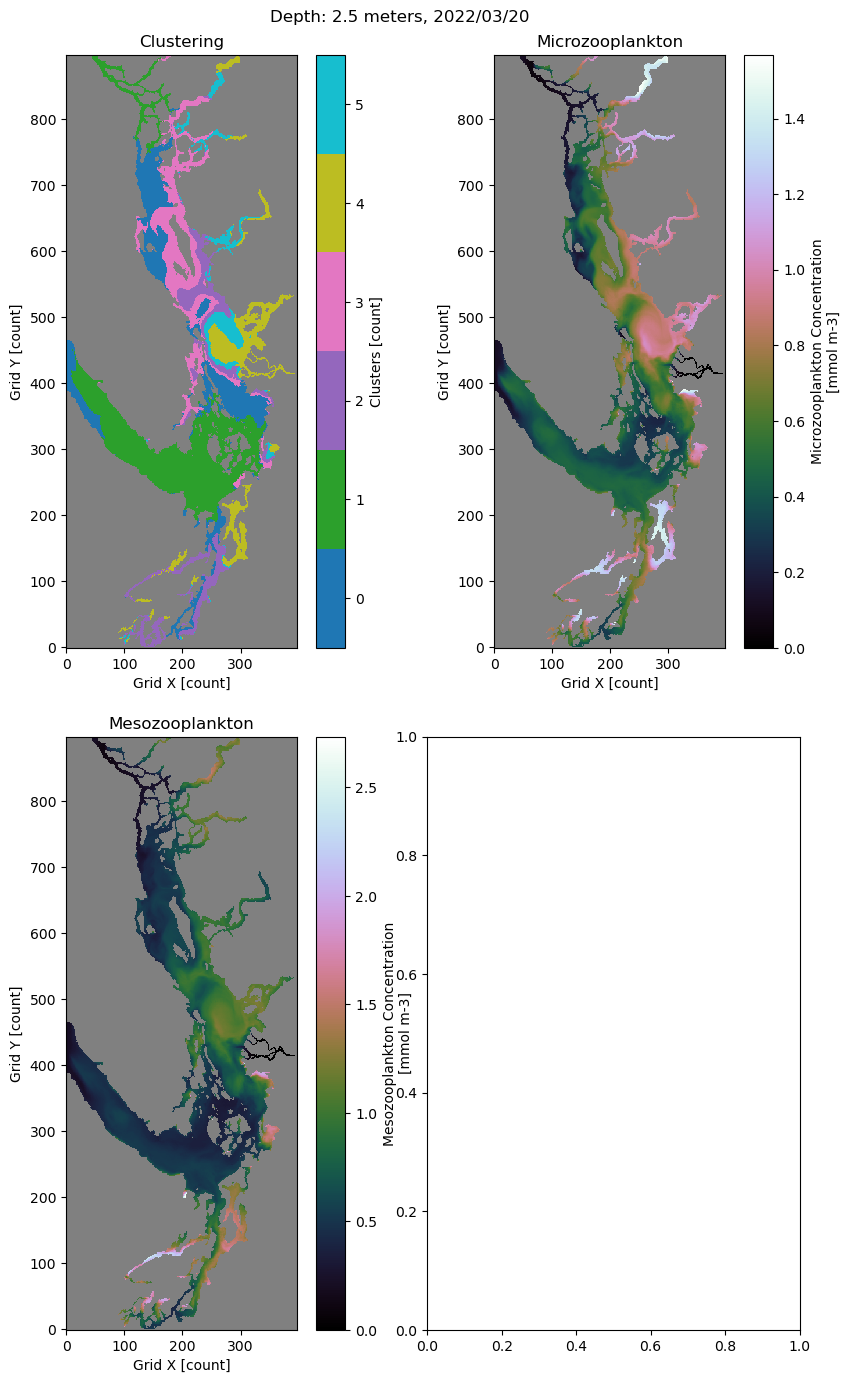

The amount of grid boxes for cluster 0 is 5702 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 8.84 degrees Celsius
The mean temperature for cluster 0 is 7.5 degrees Celsius 

The minimum salinity for cluster 0 is 23.91 g/kg
The maximum salinity for cluster 0 is 26.89 g/kg
The mean salinity for cluster 0 is 25.24 g/kg 


The amount of grid boxes for cluster 1 is 8709 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 10.03 degrees Celsius
The mean temperature for cluster 1 is 7.6 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 24.43 g/kg
The mean salinity for cluster 1 is 20.22 g/kg 


The amount of grid boxes for cluster 2 is 12356 

The minimum temperature for cluster 2 is 5.81 degrees Celsius
The maximum temperature for cluster 2 is 8.04 degrees Celsius
The mean temperature for cluster 2 is 7.56 degrees Celsius 

The mi

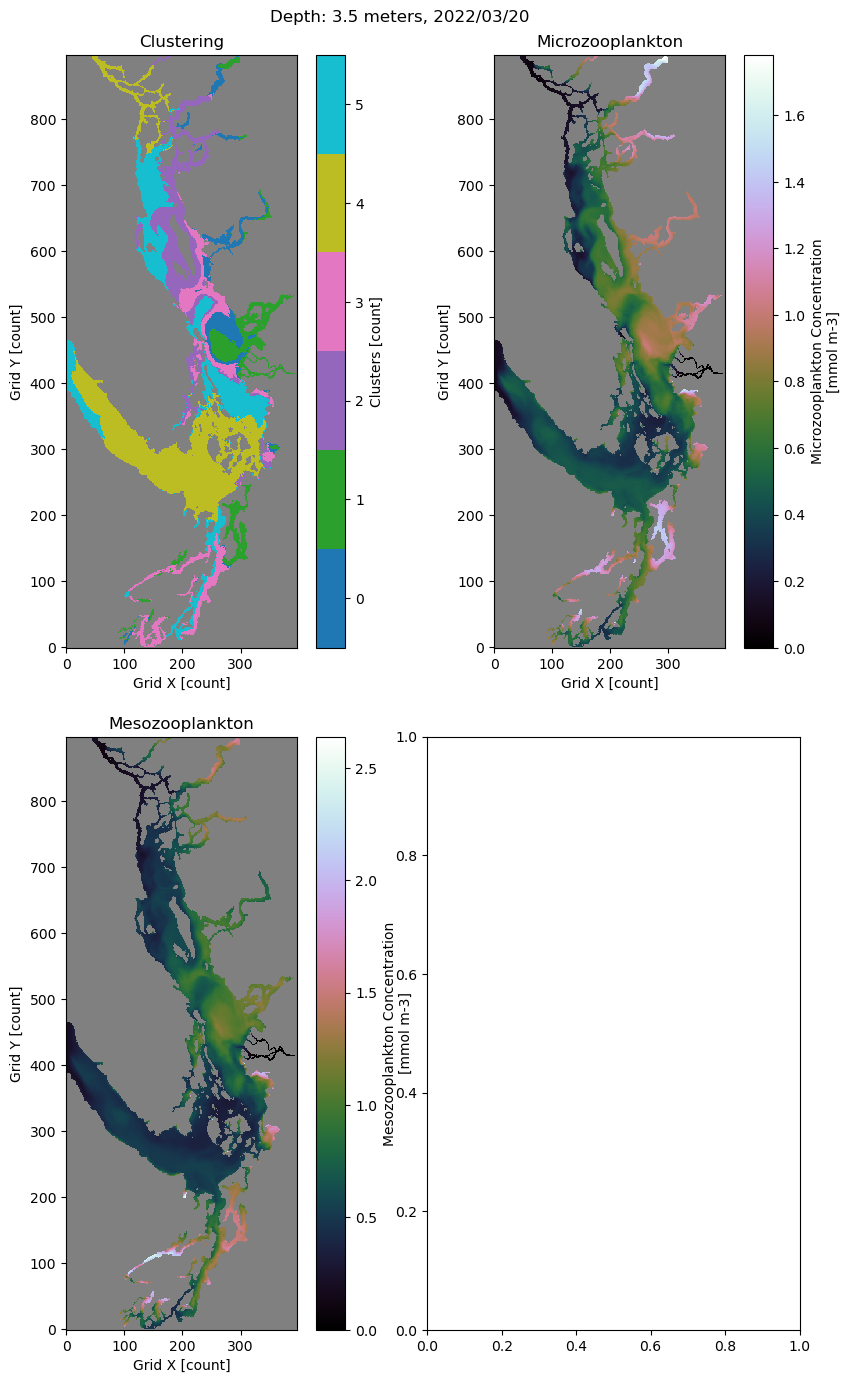

The amount of grid boxes for cluster 0 is 26916 

The minimum temperature for cluster 0 is 6.88 degrees Celsius
The maximum temperature for cluster 0 is 8.51 degrees Celsius
The mean temperature for cluster 0 is 7.74 degrees Celsius 

The minimum salinity for cluster 0 is 29.19 g/kg
The maximum salinity for cluster 0 is 31.26 g/kg
The mean salinity for cluster 0 is 30.14 g/kg 


The amount of grid boxes for cluster 1 is 5671 

The minimum temperature for cluster 1 is 5.74 degrees Celsius
The maximum temperature for cluster 1 is 7.87 degrees Celsius
The mean temperature for cluster 1 is 7.55 degrees Celsius 

The minimum salinity for cluster 1 is 28.27 g/kg
The maximum salinity for cluster 1 is 30.63 g/kg
The mean salinity for cluster 1 is 28.88 g/kg 


The amount of grid boxes for cluster 2 is 17893 

The minimum temperature for cluster 2 is 7.6 degrees Celsius
The maximum temperature for cluster 2 is 8.88 degrees Celsius
The mean temperature for cluster 2 is 7.98 degrees Celsius 

The

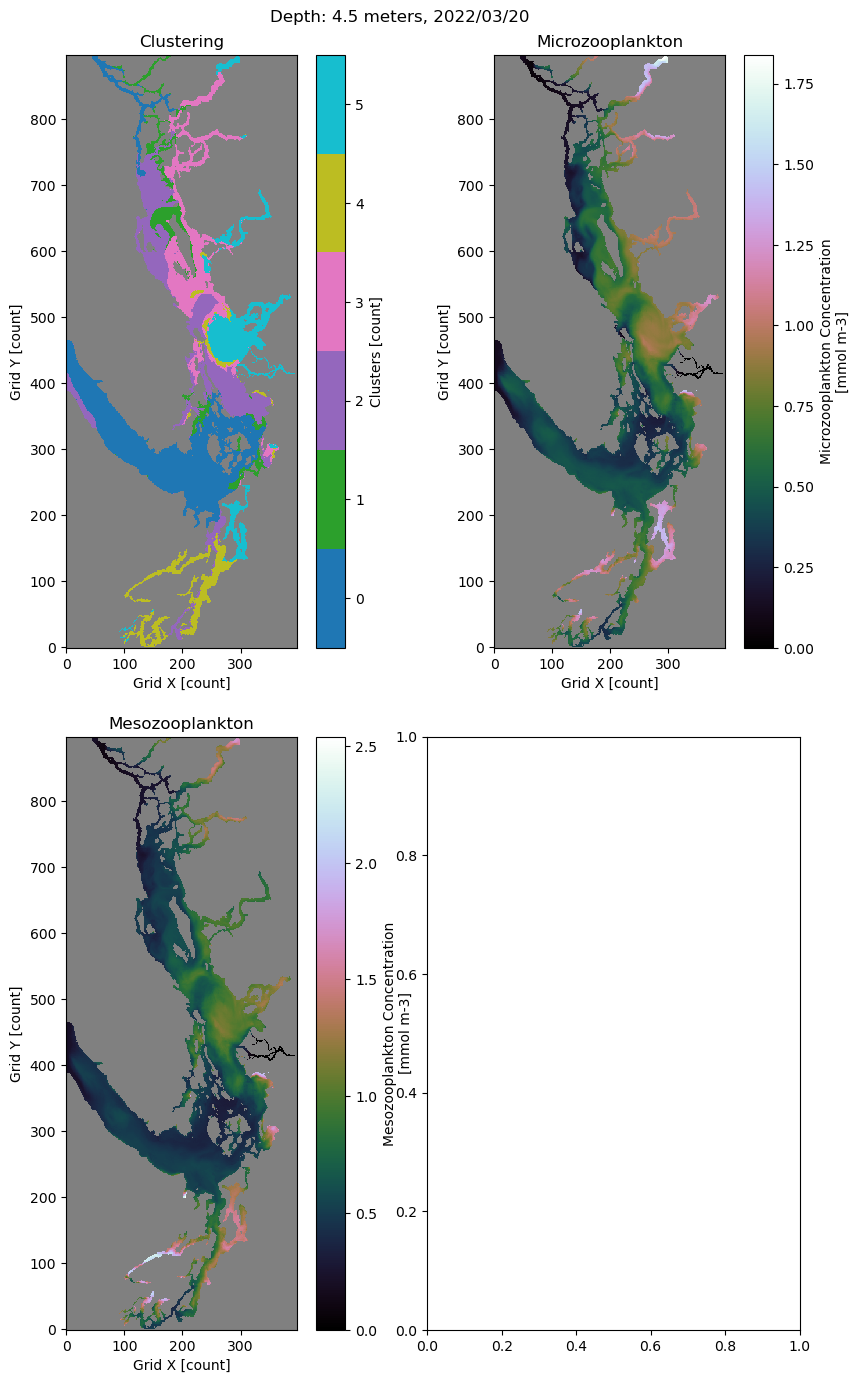

The amount of grid boxes for cluster 0 is 12328 

The minimum temperature for cluster 0 is 7.75 degrees Celsius
The maximum temperature for cluster 0 is 8.51 degrees Celsius
The mean temperature for cluster 0 is 8.02 degrees Celsius 

The minimum salinity for cluster 0 is 28.56 g/kg
The maximum salinity for cluster 0 is 30.17 g/kg
The mean salinity for cluster 0 is 29.18 g/kg 


The amount of grid boxes for cluster 1 is 25307 

The minimum temperature for cluster 1 is 5.74 degrees Celsius
The maximum temperature for cluster 1 is 8.03 degrees Celsius
The mean temperature for cluster 1 is 7.68 degrees Celsius 

The minimum salinity for cluster 1 is 29.0 g/kg
The maximum salinity for cluster 1 is 31.28 g/kg
The mean salinity for cluster 1 is 30.18 g/kg 


The amount of grid boxes for cluster 2 is 10696 

The minimum temperature for cluster 2 is 7.74 degrees Celsius
The maximum temperature for cluster 2 is 10.23 degrees Celsius
The mean temperature for cluster 2 is 8.36 degrees Celsius 

T

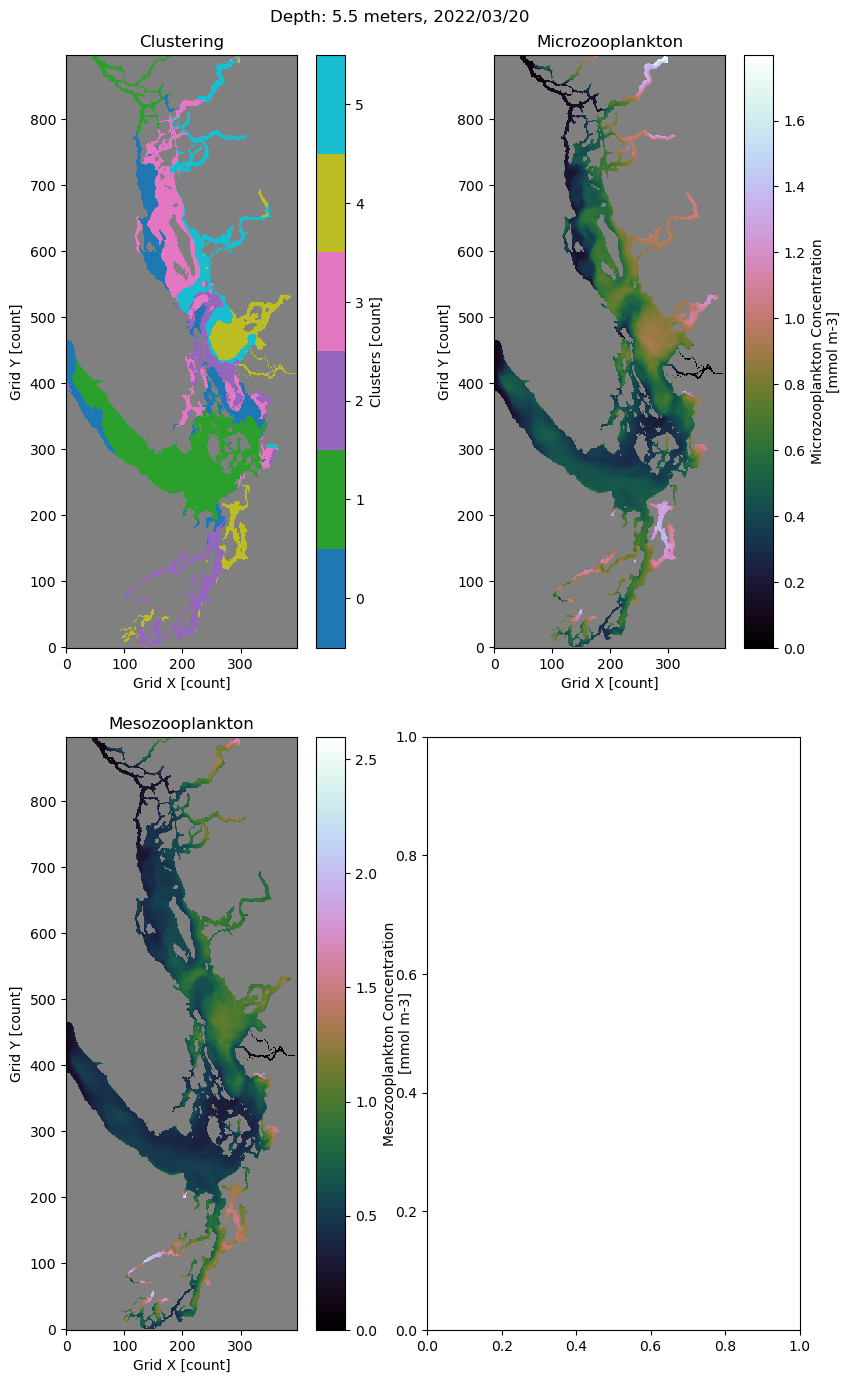

The amount of grid boxes for cluster 0 is 10040 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 8.82 degrees Celsius
The mean temperature for cluster 0 is 7.56 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.23 g/kg
The mean salinity for cluster 0 is 24.49 g/kg 


The amount of grid boxes for cluster 1 is 7797 

The minimum temperature for cluster 1 is 7.85 degrees Celsius
The maximum temperature for cluster 1 is 10.24 degrees Celsius
The mean temperature for cluster 1 is 8.62 degrees Celsius 

The minimum salinity for cluster 1 is 23.89 g/kg
The maximum salinity for cluster 1 is 29.03 g/kg
The mean salinity for cluster 1 is 27.33 g/kg 


The amount of grid boxes for cluster 2 is 14893 

The minimum temperature for cluster 2 is 6.83 degrees Celsius
The maximum temperature for cluster 2 is 7.96 degrees Celsius
The mean temperature for cluster 2 is 7.57 degrees Celsius 

The

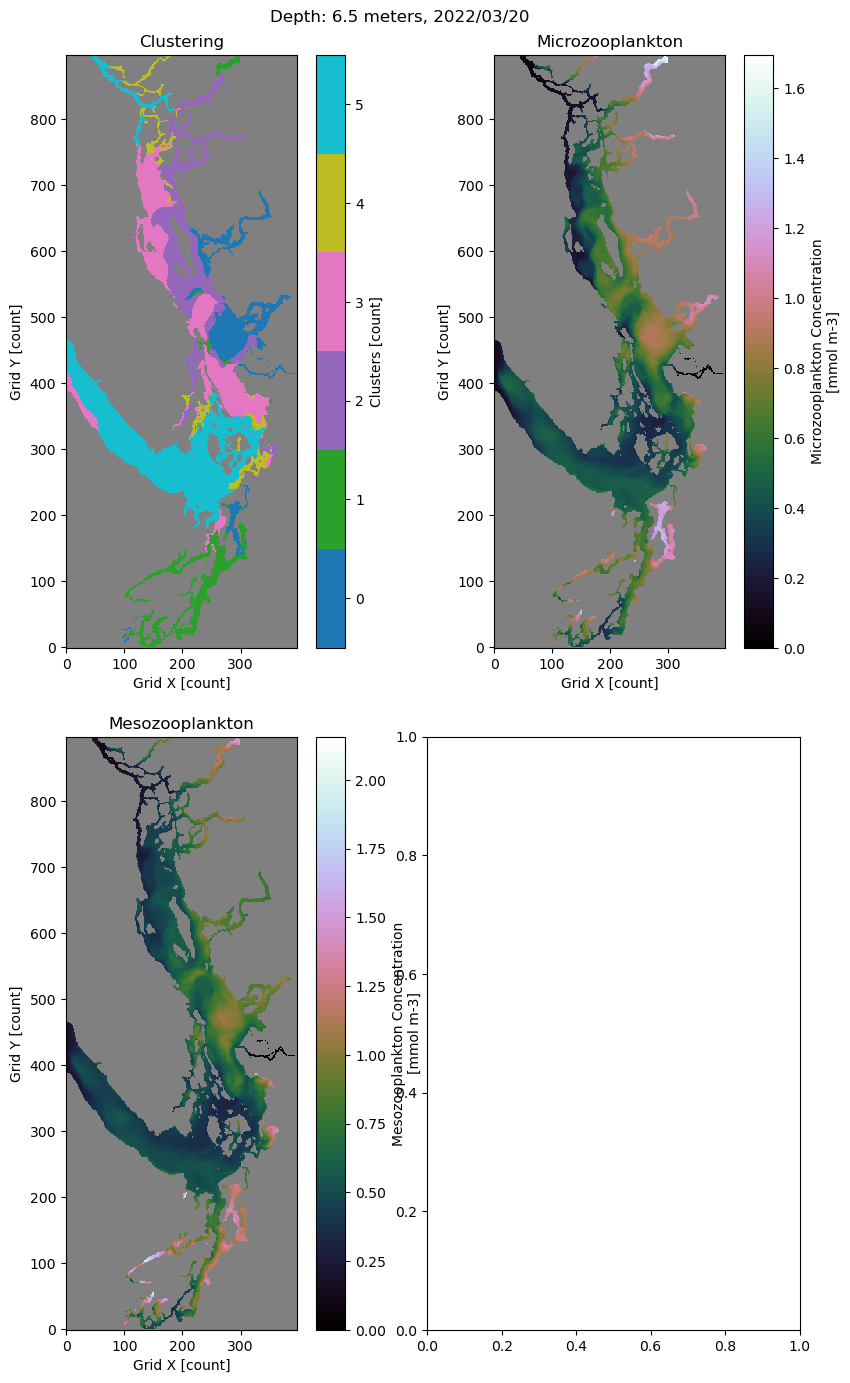

The amount of grid boxes for cluster 0 is 9502 

The minimum temperature for cluster 0 is 7.85 degrees Celsius
The maximum temperature for cluster 0 is 10.23 degrees Celsius
The mean temperature for cluster 0 is 8.6 degrees Celsius 

The minimum salinity for cluster 0 is 22.98 g/kg
The maximum salinity for cluster 0 is 29.12 g/kg
The mean salinity for cluster 0 is 27.34 g/kg 


The amount of grid boxes for cluster 1 is 9690 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 8.7 degrees Celsius
The mean temperature for cluster 1 is 7.48 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 27.68 g/kg
The mean salinity for cluster 1 is 25.52 g/kg 


The amount of grid boxes for cluster 2 is 15898 

The minimum temperature for cluster 2 is 7.72 degrees Celsius
The maximum temperature for cluster 2 is 8.52 degrees Celsius
The mean temperature for cluster 2 is 7.99 degrees Celsius 

The mi

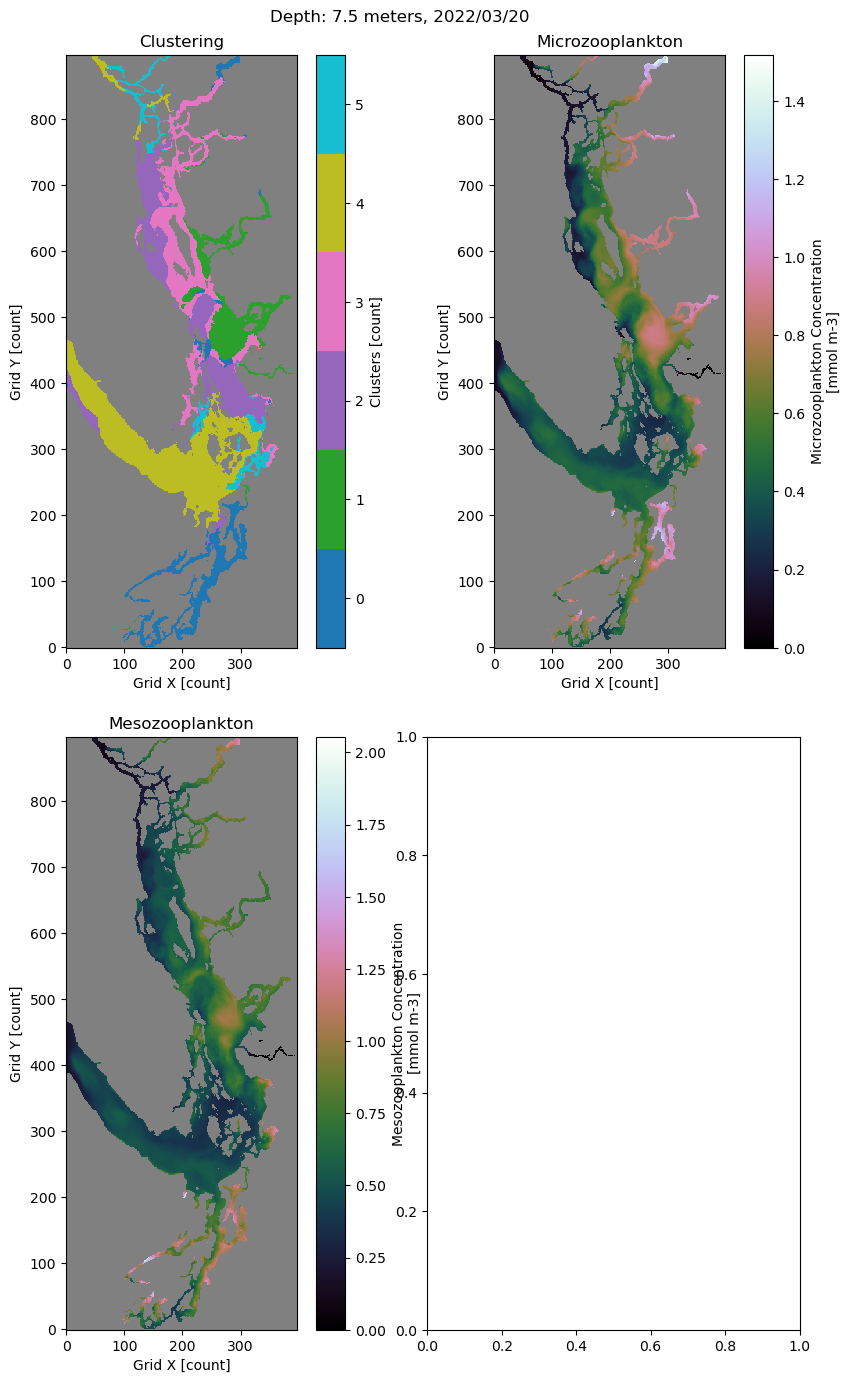

The amount of grid boxes for cluster 0 is 11662 

The minimum temperature for cluster 0 is 7.99 degrees Celsius
The maximum temperature for cluster 0 is 10.23 degrees Celsius
The mean temperature for cluster 0 is 8.54 degrees Celsius 

The minimum salinity for cluster 0 is 22.88 g/kg
The maximum salinity for cluster 0 is 29.8 g/kg
The mean salinity for cluster 0 is 27.94 g/kg 


The amount of grid boxes for cluster 1 is 8080 

The minimum temperature for cluster 1 is 7.83 degrees Celsius
The maximum temperature for cluster 1 is 8.35 degrees Celsius
The mean temperature for cluster 1 is 8.03 degrees Celsius 

The minimum salinity for cluster 1 is 28.84 g/kg
The maximum salinity for cluster 1 is 30.3 g/kg
The mean salinity for cluster 1 is 29.39 g/kg 


The amount of grid boxes for cluster 2 is 10942 

The minimum temperature for cluster 2 is 7.7 degrees Celsius
The maximum temperature for cluster 2 is 8.02 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The 

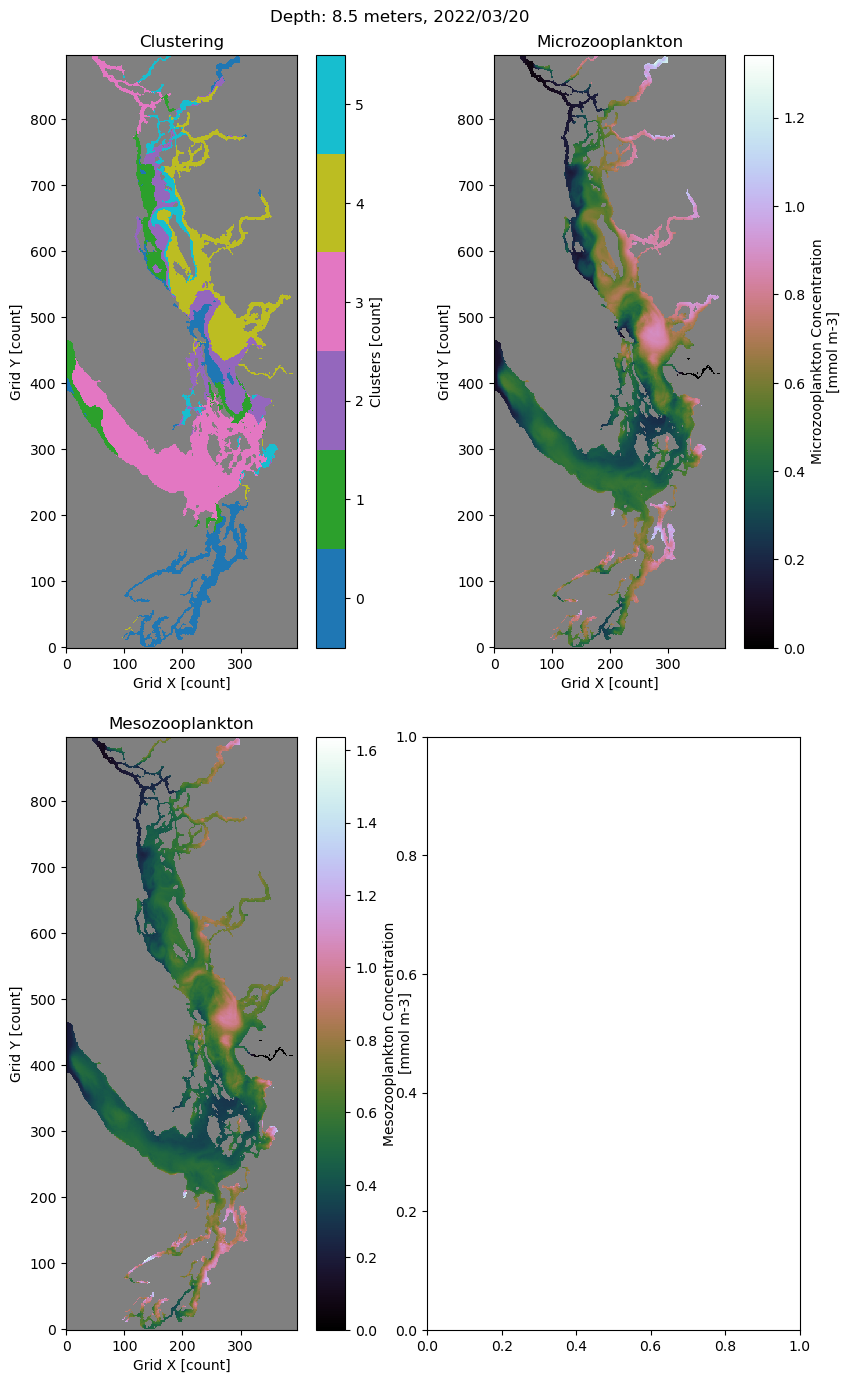

The amount of grid boxes for cluster 0 is 9702 

The minimum temperature for cluster 0 is 7.95 degrees Celsius
The maximum temperature for cluster 0 is 10.22 degrees Celsius
The mean temperature for cluster 0 is 8.64 degrees Celsius 

The minimum salinity for cluster 0 is 23.92 g/kg
The maximum salinity for cluster 0 is 29.8 g/kg
The mean salinity for cluster 0 is 27.96 g/kg 


The amount of grid boxes for cluster 1 is 8604 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 8.72 degrees Celsius
The mean temperature for cluster 1 is 7.56 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.19 g/kg
The mean salinity for cluster 1 is 26.3 g/kg 


The amount of grid boxes for cluster 2 is 14023 

The minimum temperature for cluster 2 is 7.78 degrees Celsius
The maximum temperature for cluster 2 is 8.47 degrees Celsius
The mean temperature for cluster 2 is 8.01 degrees Celsius 

The mi

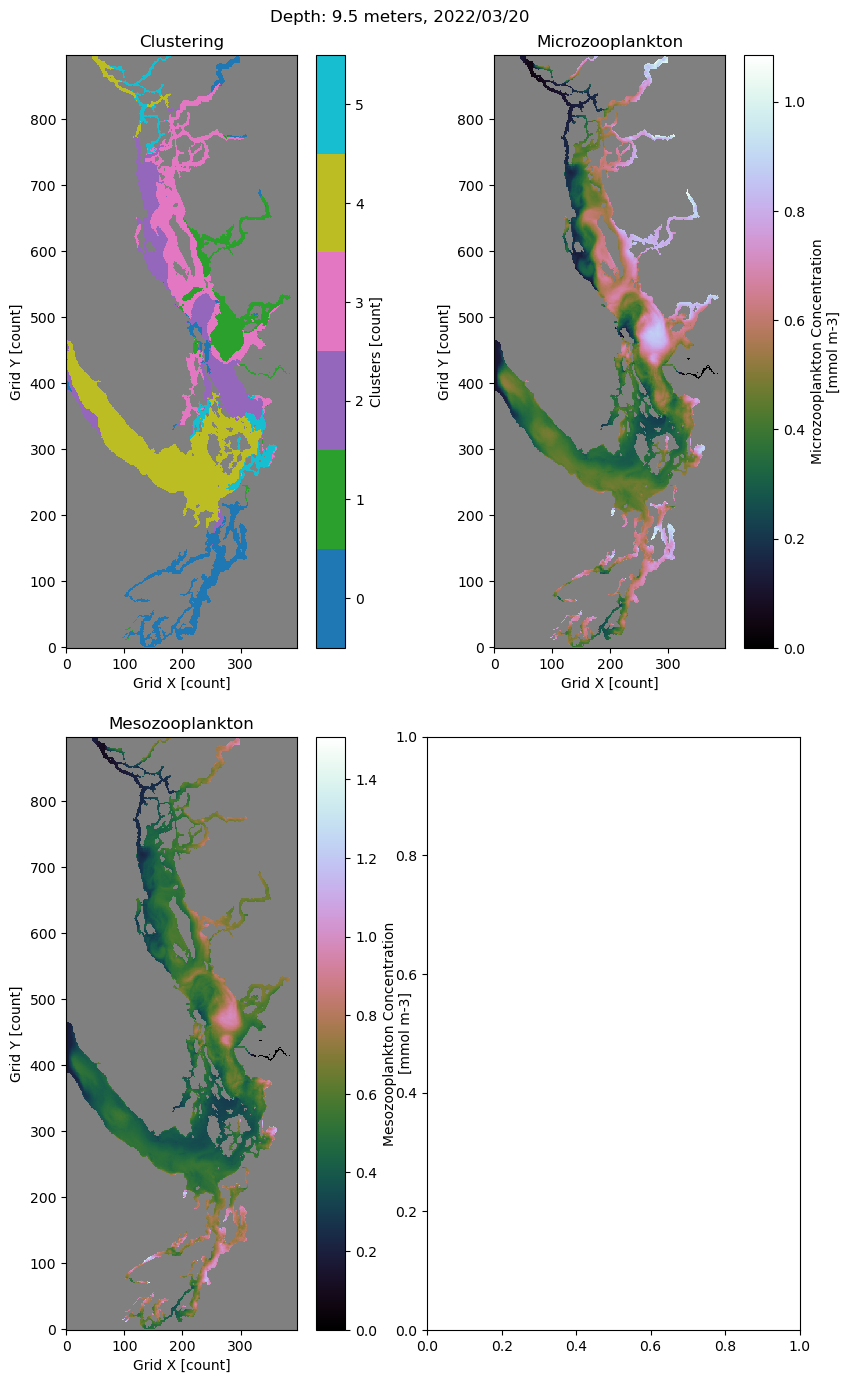

In [7]:
ds, temp, saline, date, mask, micro, meso = datasets_preparation()

for depth in range (0, 10):

    temp, saline, micro, meso = masking(depth, temp, saline, mask, micro, meso)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, micro, meso)
